# CharityScore aims to provide a measure of efficency on expenditures of Canadian charities

### This program is divided into three parts: Data Collection, Statistical Calculation, and Scoring Algorithm.

### The final product is a dataframe consisting of a letter grade for each charity with available information. I hope to soon produce a web application to allow users to search for individual charities and view their scores.

### Written by: Muhammad Ibrahim
#### Data Credits: charitydata.ca (sourced from CRA T3010 returns)

##### Disclaimer: This is an attempt to create transparency in the non-profit sector (something I believe is very important) and showcase my programming ability.  A low score is not intended to mean that the charity is conducting itself illegitamtely or poorly. All data is reported as is from charitydata.ca and may not represent the latest information.


## Part 1: Data Collection
#### Tools: Selenium Webdriver and Pandas

In [ ]:
#importing required libraries and setting the driver path
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

driver_path = "C:/Users/16475/Documents/GitHub/CharityScore.ca/chromedriver.exe"
driver = webdriver.Chrome(executable_path=driver_path)

#create base dataframe
test_url = "https://www.charitydata.ca/charity/full-name/000000000000001"
full_name = ' '.join(test_url.split("/")[4].split("-"))
brn = test_url.split("/")[5]
df = pd.DataFrame([[test_url,full_name,brn]], columns=['URL',"Name","BRN"])

#script for going to charitydata.ca and parsing data into a dataframe
#open index with all charities
base_url = "https://www.charitydata.ca/index/"
driver.get(base_url)

# list of urls that should be excluded
exclusions = open("url exclusions.txt").read().splitlines()

#compile list of charity urls (each url page has that charities information)
#there are 3364 pages of charity urls so this is the number of iterations
for i in range(2,3365):
    #the 'a' tag is given to each URL in the HTML source, find all the tags
    link_objects = driver.find_elements_by_tag_name("a")
    
    #the href attribute pulls just the URL, instead of the all associated HTML syntax elements
    for x in link_objects:
        #charity specific url
        charity_url = x.get_attribute("href")
        
        if charity_url not in exclusions and len(charity_url) > 0 and charity_url[:5]=="https":
            full_name = ' '.join(charity_url.split("/")[4].split("-"))
            brn = charity_url.split("/")[5]
            df = df.append({"URL": charity_url, "Name": full_name, "BRN": brn}, ignore_index=True)
    
    driver.get(base_url + str(i))

driver.quit()
df.to_csv("data.csv")

In [ ]:
## ONCE ALL URLS, Names, BRNs are collected, proceed to scrape the expense data:
# this process can likely be spend up using async, working to update this in the future

# import the url data from the dataframe
df = pd.read_csv("expense data.csv")
# remove duplicate index column
df = pd.read_csv("expense data.csv").drop(['Unnamed: 0'],axis=1)

# find expense tables on charitydata.ca and add them to the dataframe as 
# string representations of dictionaries

for i in range(78000, len(df)):
    driver.get(df.loc[i,"URL"])
    
    # check if url page found, else skip
    try:
        url_check = driver.find_element_by_xpath \
        ("/html/body/main/div/section[2]/div/div[2]/p").text
    except NoSuchElementException:
        url_check = ""
    
    if url_check == "The requested page could not be found.":
        continue
    
    # open expense table
    try:
        WebDriverWait(driver, 30).until \
        (EC.presence_of_element_located((By.LINK_TEXT, 'Expenses'))).click()
        expense_table = driver.find_element_by_xpath \
        ('//html/body/main/div/section[3]/div/div[2]/div[4]/div[2]/table[1]')
    except TimeoutException:
        try:
            driver.get(df.loc[i,"URL"])
            WebDriverWait(driver, 30).until \
            (EC.presence_of_element_located((By.LINK_TEXT, 'Expenses'))).click()
            expense_table = driver.find_element_by_xpath \
            ('//html/body/main/div/section[3]/div/div[2]/div[4]/div[2]/table[1]')
        except:
            continue
    
    # create dictionary representation of expense table
    expense_dict = {}
    
    expense_rows = expense_table.find_elements(By.TAG_NAME, "tr")
    header_row = expense_rows.pop(0)
    
    headers = header_row.find_elements(By.TAG_NAME, "th")
    header_key = headers.pop(0).text
    headers = list(map(lambda x: int(x.text), headers))
    expense_dict[header_key] = headers 
    
    for row in expense_rows:
        row_key = row.find_element(By.TAG_NAME, "th").text
        row_series = row.find_elements(By.TAG_NAME, "td")
        num_list = []
        
        for num in row_series:
            if num.text[0] != "(":
                num_list +=[int(num.text.replace(",",""))]
            else:
                num_list += [int(num.text[1:-1].replace(",",""))]
                
        expense_dict[row_key] = num_list
        
    df.loc[df.index[i], 'Expense_Table'] = str(expense_dict)
    df.to_csv("expense data.csv")
    
# quit driver and export to csv  
driver.quit()
df.to_csv("expense data.csv")

## Part 2: Statistical Calculation
#### Tools: Pandas, NumPy, Matplotlib

In [ ]:
# Adding columns for averages and percentages of expenditures per category
import pandas as pd
import numpy as np
import ast

# import the url data from the dataframe
df = pd.read_csv("expense data.csv")
# remove duplicate index column
df = pd.read_csv("expense data.csv").drop(['Unnamed: 0'],axis=1)
# create list of common keys to access by index rather than name
ck = list(ast.literal_eval(df.loc[1,"Expense Table"]).keys())

# for each line in the dataframe, find the expense dictionary and create arrays for each bucket 
for i in range(1,len(df)):
    if df.loc[i, "Expense Table"] != "":
        try:
            expense_dict = ast.literal_eval(df.loc[i, "Expense Table"])
        except ValueError:
            expense_dict = None
    
    if expense_dict != None:
        reporting_years = expense_dict[ck[0]]
        total_exp = expense_dict[ck[7]]
        charitable_exp = expense_dict[ck[1]]
        mgmt_exp = expense_dict[ck[2]]
        fundraising_exp = expense_dict[ck[3]]
        pol_exp = expense_dict[ck[4]]
        other_exp = expense_dict[ck[5]]
        gift_exp = expense_dict[ck[6]]
        
        expense_matrix = np.matrix([reporting_years, total_exp, charitable_exp, mgmt_exp, \
                                    fundraising_exp, pol_exp, gift_exp, other_exp])
        
        # create a new columns with values from most recent year
        df.loc[i, 'Reporting Year'] = expense_matrix[:,0][0].item()
        df.loc[i, 'Total Expenditure'] = expense_matrix[:,0][1].item()
        df.loc[i, 'Total Expenditure on Charitable Activities'] = expense_matrix[:,0][2].item()
        df.loc[i, 'Total Expenditure on Management and Administration'] = expense_matrix[:,0][3].item()
        df.loc[i, 'Total Expenditures on Fundraising'] = expense_matrix[:,0][4].item()
        df.loc[i, 'Total Expenditures on Political Activities'] = expense_matrix[:,0][5].item()
        df.loc[i, 'Total Other Expenditures'] = expense_matrix[:,0][6].item()
        df.loc[i, 'Total Amount of Gifts Made to All Qualified Donees'] = expense_matrix[:,0][7].item()
        
        df.to_csv("expense data calcs.csv")
        
    else:
        df.loc[i, ['Reporting Year', 'Total Expenditure','Total Expenditure on Charitable Activities',\
                   'Total Expenditure on Management and Administration', \
                   'Total Expenditures on Fundraising', 'Total Expenditures on Political Activities',\
                   'Total Other Expenditures', 'Total Amount of Gifts Made to All Qualified Donees']]\
        = 0

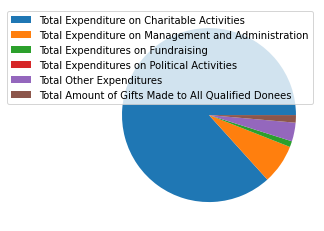

Average Total Expenditure on Charitable Activities: $3,432,075.82
Average Total Expenditure on Management and Administration: $290,176.57
Average Total Expenditures on Fundraising: $43,106.03
Average Total Expenditures on Political Activities: $7.09
Average Total Other Expenditures: $137,456.83
Average Total Amount of Gifts Made to All Qualified Donees: $55,476.47


In [3]:
## Calculate column averages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("expense data calcs.csv").drop(['Unnamed: 0'],axis=1)
# get index values of rows which have total expenditure = 0
index_values = df[ df['Total Expenditure'] == 0 ].index
df = df.drop(df.index[index_values])

# get expenditure category averages
total_avg = df['Total Expenditure'].mean()
charitable_avg = df['Total Expenditure on Charitable Activities'].mean()
mgmt_avg = df['Total Expenditure on Management and Administration'].mean()
fund_avg = df['Total Expenditures on Fundraising'].mean()
pol_avg = df['Total Expenditures on Political Activities'].mean()
other_avg = df['Total Other Expenditures'].mean()
gift_avg = df['Total Amount of Gifts Made to All Qualified Donees'].mean()

# Create a pie chart representation of the average Canadian charity expenditure
chart_values = np.array([charitable_avg, mgmt_avg, fund_avg, pol_avg, other_avg, gift_avg])
chart_labels = ['Total Expenditure on Charitable Activities', \
                'Total Expenditure on Management and Administration', \
                'Total Expenditures on Fundraising', 'Total Expenditures on Political Activities', \
                   'Total Other Expenditures', 'Total Amount of Gifts Made to All Qualified Donees']

plt.pie(chart_values)
plt.legend(chart_labels)
plt.show()
print("Average Total Expenditure on Charitable Activities: " + "${:,.2f}".format(charitable_avg))
print("Average Total Expenditure on Management and Administration: " + "${:,.2f}".format(mgmt_avg))
print("Average Total Expenditures on Fundraising: " +"${:,.2f}".format(fund_avg))
print("Average Total Expenditures on Political Activities: " + "${:,.2f}".format(pol_avg))
print("Average Total Other Expenditures: " + "${:,.2f}".format(other_avg))
print("Average Total Amount of Gifts Made to All Qualified Donees: " + "${:,.2f}".format(gift_avg))

## Part 3: Scoring Algorithm
#### Tools: Pandas, NumPy

In [9]:
import pandas as pd
import numpy as np

df = pd.read_csv("expense data calcs.csv").drop(['Unnamed: 0'],axis=1)

# to avoid division by zero, remove index values where ratio denominator is 0
 #index_values = df[ df['Total Expenditures on Fundraising', \
                     # 'Total Expenditure on Management and Administration' ] == 0 ].index
#df = df.drop(df.index[index_values])

# calculate Efficiency Ratio
# Efficiency Ratio = Total Expenditure on Charitable Activities / (Total Expenditure on Management
# and Administration + Total Expenditure on Fundraising)
df['Efficiency Ratio'] = \
df['Total Expenditure on Charitable Activities']  / \
(df['Total Expenditures on Fundraising'] + df['Total Expenditure on Management and Administration'])

# create ratio percentile column
df['Ratio Percentile'] = df['Efficiency Ratio'].rank(pct=True)

# define a function to derive a letter score
def efficiencyScore(row):
    if row['Ratio Percentile'] >= .9:
        value = "S"
    elif row['Ratio Percentile'] >= .8:
        value = "A"
    elif row['Ratio Percentile'] >= .6:
        value = "B"
    elif row['Ratio Percentile'] >= .4:
        value = "C"
    elif row['Ratio Percentile'] >= .2:
        value = "D"
    else:
        value = "N"
    
    return(value)

# create letter score column
df['Overall Score'] = df.apply(efficiencyScore, axis=1)

df.to_csv("Final Output.csv")
print(df.head(5))

                                                 URL  \
0  https://www.charitydata.ca/charity/full-name/0...   
1  https://www.charitydata.ca/charity/bethesda-ro...   
2  https://www.charitydata.ca/charity/cafe-commun...   
3  https://www.charitydata.ca/charity/camp-courag...   
4  https://www.charitydata.ca/charity/chants-libr...   

                                                Name              BRN  \
0                                          full name                1   
1                    bethesda romanian church of god  875769515RR0001   
2  cafe communautaire lentre gens de sainte adele...  892458076RR0001   
3          camp courage the first responders society  858394364RR0001   
4        chants libres compagnie lyrique de creation  140382375RR0001   

                                       Expense Table  Reporting Year  \
0                                                NaN             NaN   
1  {'Expenditures by 6 Groups': [2020, 2019, 2018...          2020.0   
2  {'Exp